In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)
meas_FLAT = meas_FLAT[meas_FLAT['N']<2.4e7]
meas_FLAT = meas_FLAT.sort_values(by='N',ignore_index=True)

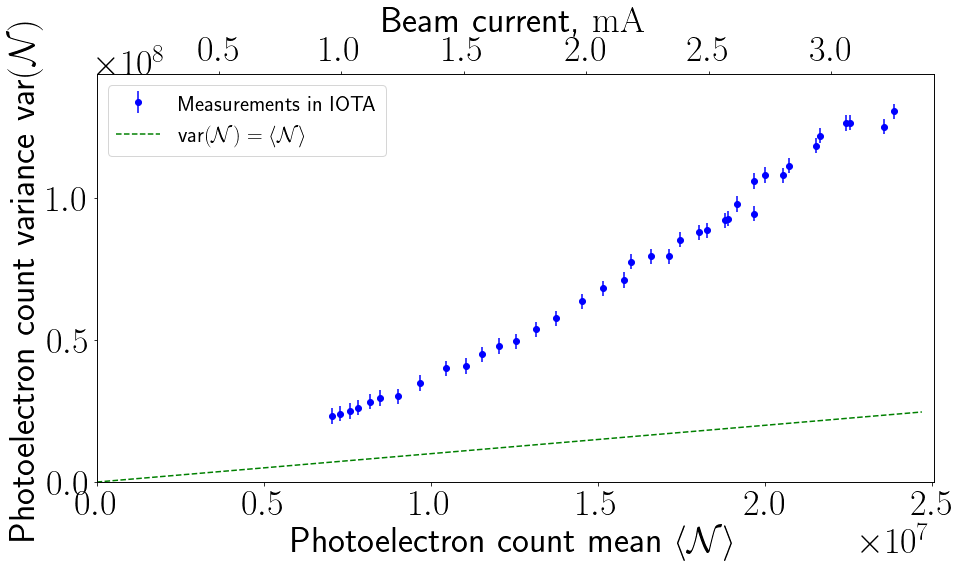

In [2]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_FLAT['N'],meas_FLAT['varN'],marker='o',linestyle='None',yerr=meas_FLAT['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_FLAT['N'].max())
ax.set_ylim(0, 1.1*meas_FLAT['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [3]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)

In [4]:
df.head()

,0.001,0.003111111111111111,0.005222222222222222,0.007333333333333333,0.009444444444444443,0.011555555555555555,0.013666666666666667,0.015777777777777776,0.017888888888888888,0.02
7.033813e+06,2.568831e+06,2.912394e+06,3.207583e+06,3.473546e+06,3.712491e+06,3.933485e+06,4.140681e+06,4.336079e+06,4.521700e+06,4.698871e+06
7.281579e+06,2.595229e+06,2.942203e+06,3.240408e+06,3.509092e+06,3.750476e+06,3.973720e+06,4.183020e+06,4.380408e+06,4.567921e+06,4.746895e+06
7.565539e+06,2.624092e+06,2.974850e+06,3.276327e+06,3.547955e+06,3.791991e+06,4.017693e+06,4.229297e+06,4.428851e+06,4.618419e+06,4.799354e+06
7.831848e+06,2.649171e+06,3.003225e+06,3.307567e+06,3.581760e+06,3.828105e+06,4.055930e+06,4.269528e+06,4.470968e+06,4.662327e+06,4.844973e+06
8.180763e+06,2.681937e+06,3.040315e+06,3.348379e+06,3.625901e+06,3.875252e+06,4.105859e+06,4.322060e+06,4.525951e+06,4.719638e+06,4.904502e+06


In [5]:
eys = df.columns.values.astype(np.float64)

In [6]:
eys

array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])

In [7]:
def reconstruct_ey(avN, varN):
    Mexp = avN**2/(varN-avN)
    return np.interp(Mexp,df.loc[avN,:],eys)

In [8]:
meas_FLAT.head()

,N,varN,errorbar,Sigma_um_X,Sigma_um_Y,N:IWCMBE,ey_rec,varNtop,varNbottom,ey_error_top,ey_error_bottom,I_mA,sy_rec
0,7.033813e+06,2.327259e+07,2.688549e+06,1072.667246,68.017764,27.527364,0.004072,2.596114e+07,2.058404e+07,0.004831,0.002794,0.960590,63.300784
1,7.281579e+06,2.403584e+07,2.688549e+06,1077.585251,68.387617,27.680173,0.004686,2.672439e+07,2.134729e+07,0.004939,0.002884,0.994426,67.908800
2,7.565539e+06,2.507256e+07,2.688549e+06,1083.501358,68.805774,27.830620,0.005174,2.776111e+07,2.238401e+07,0.004931,0.002909,1.033206,71.355732
3,7.831848e+06,2.624953e+07,2.688549e+06,1087.783601,68.966918,27.936232,0.005398,2.893808e+07,2.356098e+07,0.004709,0.002866,1.069575,72.885231
4,8.180763e+06,2.828818e+07,2.688549e+06,1094.360657,69.428513,28.139613,0.005085,3.097673e+07,2.559963e+07,0.004079,0.002590,1.117226,70.742118


In [9]:
reconstruct_ey(meas_FLAT['N'][0], meas_FLAT['varN'][0]+0.01e8)

0.002850331482188667

In [10]:
reconstruct_ey(meas_FLAT['N'][0], meas_FLAT['varN'][0])

0.00407155673581416

In [11]:
meas_FLAT['ey_rec'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(*row[['N', 'varN']]), axis=1)
meas_FLAT['varNtop'] = meas_FLAT['varN']+meas_FLAT['errorbar']
meas_FLAT['varNbottom'] = meas_FLAT['varN']-meas_FLAT['errorbar']
meas_FLAT['ey_error_top'] = meas_FLAT.apply(
    lambda row: reconstruct_ey(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_FLAT['ey_rec']
meas_FLAT['ey_error_bottom'] = -meas_FLAT.apply(
    lambda row: reconstruct_ey(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_FLAT['ey_rec']

In [12]:
meas_FLAT['I_mA'] = meas_FLAT['N']*N_to_I

In [13]:
# calculation of reconstructed sy
from lattice.summary_in_undulator import CalcTransverseBeamParams
import lattice.lattice as lattice
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
def get_sy(row):
    Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
        lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
    return np.sqrt(Sy**2+syp**2*dy**2)
meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [14]:
# save new meas_FLAT with ey and I_mA
meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

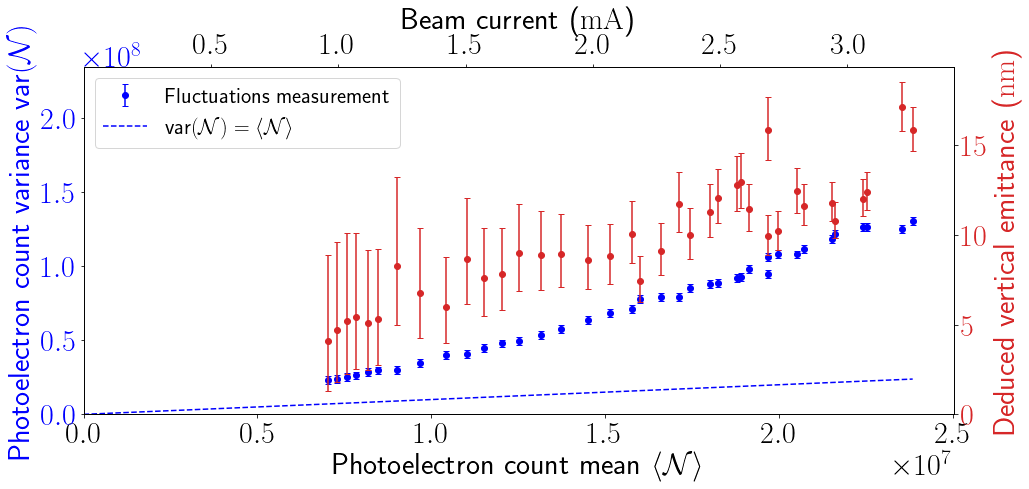

In [15]:
plt.rcParams.update({'font.size': 30,
                     'legend.fontsize':22,
                     'errorbar.capsize': 3})

fig, ax1 = plt.subplots(figsize=[15, 7.5])

color = 'blue'
ax1.set_xlabel('time (s)')
fl = ax1.errorbar(meas_FLAT['N'],meas_FLAT['varN'],marker='o',linestyle='None',
             yerr=meas_FLAT['errorbar'],color=color,
             label = r'Fluctuations measurement')
nrange = np.linspace(0,np.max(meas_FLAT['N']),2)

pois = ax1.plot(nrange, nrange,color=color,linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")

ax1.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$",
               color=color)
ax1.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax1.set_xlim(0, 1.05*meas_FLAT['N'].max())
ax1.set_ylim(0, 1.8*meas_FLAT['varN'].max())

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Deduced vertical emittance (\SI{}{nm})', color=color)
# we already handled the x-label with ax1
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
ax2.errorbar(meas_FLAT['N'], 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr)
ax2.set_xlim(0, ax2.get_xlim()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twiny()
ax3.set_xlabel('Beam current (\SI{}{mA})')
ax3.set_xlim(N_to_I*np.asarray(ax1.get_xlim()))
ax3.set_xticks(ticks=ax3.get_xticks()[1:-1])

handles, labels = ax1.get_legend_handles_labels()
order = [1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='upper left')


plt.savefig(shift.get_results_dir().fi("size_reconstruction.png"),
            dpi=300, bbox_inches='tight')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

In [16]:
import figure_arrange_scripts as ff
hor_separ = 0.05
v_space = 100
fontsize = 200
im_paths = [shift.get_results_dir().fi("round_beam.png"),
            shift.get_results_dir().fi("size_reconstruction.png")]
output_path = path_assistant.get_PRL_images_dir().fi("iota_measurements.png")

Result saved to /home/ilobach/FUR_Run2_experiment_paper/images/iota_measurements.png


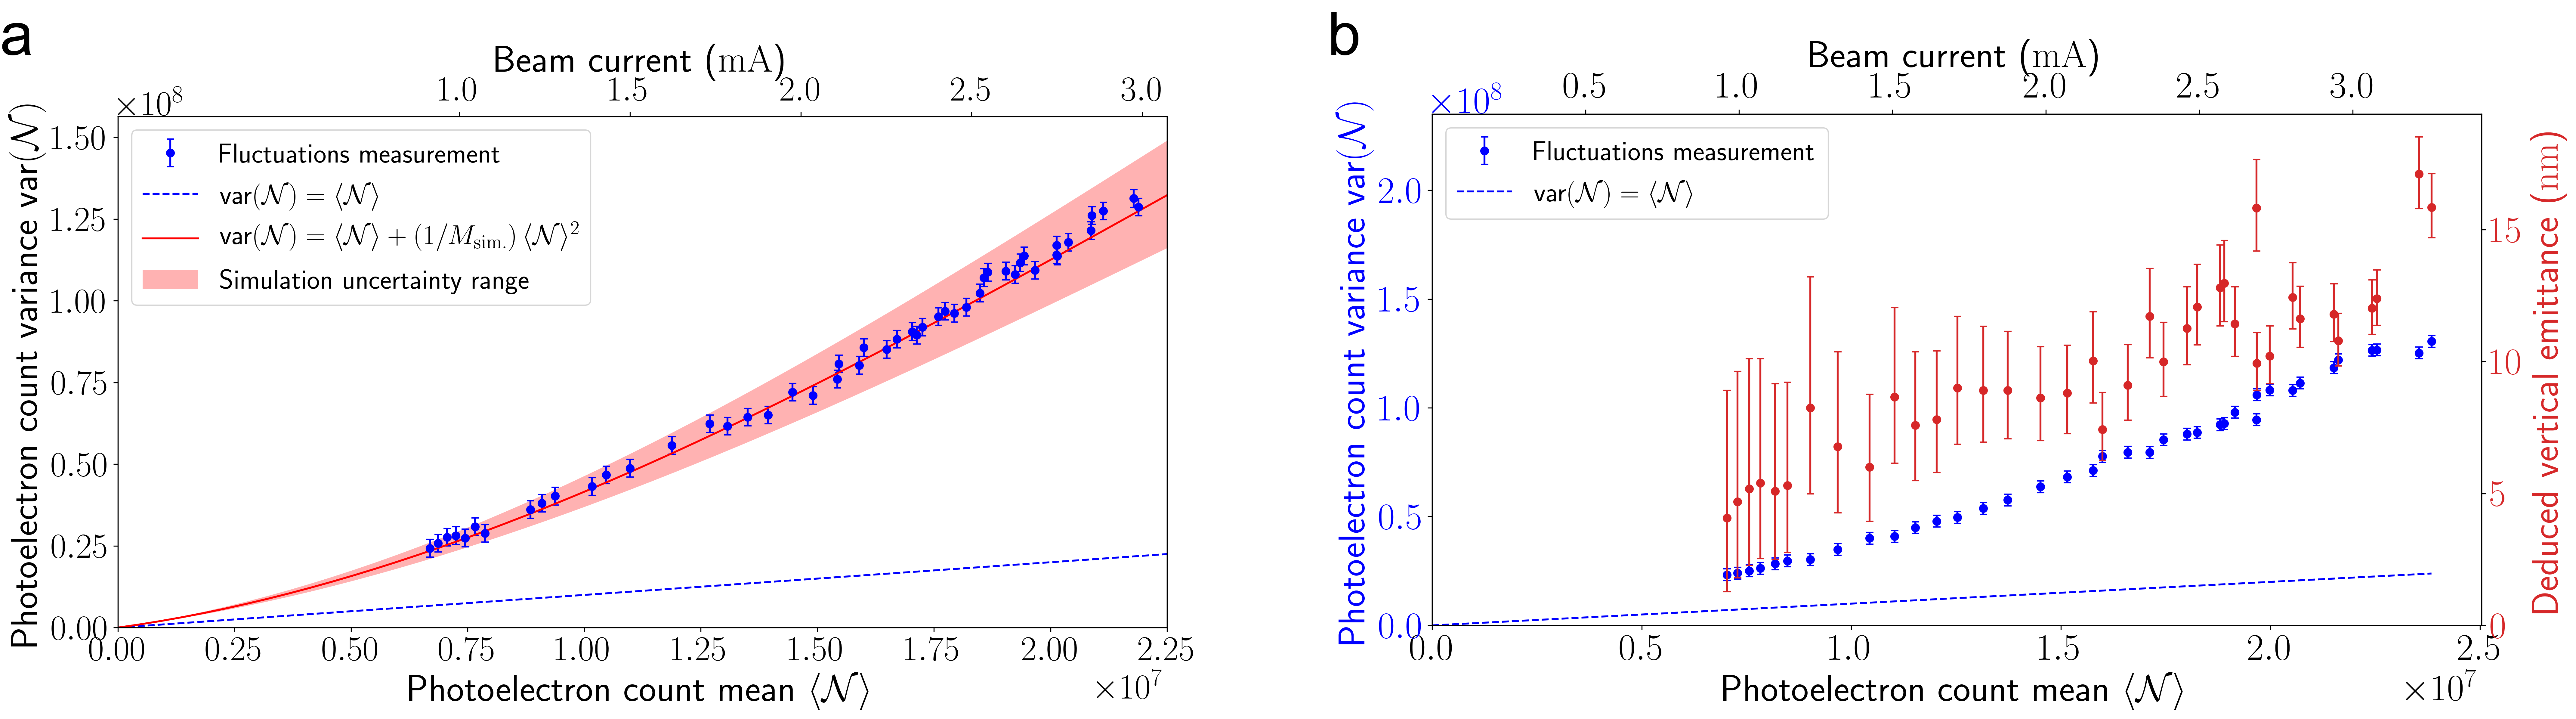

In [17]:
ff.RowOfFigures(im_paths,output_path,
                hor_separ,v_space,fontsize,display_inline=1)

In [18]:
2.29/2.355/3

0.32413305024769995